In [1]:
from __future__ import print_function
import numpy as np
import scipy.io as sio
import pandas as pd
from sklearn.metrics import mean_squared_error

np.random.seed(1333)  # for reproducibility

# from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
batch_size = 10
#nb_classes = 10
nb_epoch = 10

# input image dimensions
img_rows, img_cols = 128, 128
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# the data, shuffled and split between train and test sets
WB=sio.loadmat('sandstone_data.mat')['Data']
Y_data = sio.loadmat('sandstone_data.mat')['L']
Y_data = (Y_data-min(Y_data))/(max(Y_data)-min(Y_data))
X_data = np.reshape(WB,(768,1,img_rows,img_cols))
X_train = X_data[0:720];# X_test=X_data[720:768]
Y_train = Y_data[0:720];# Y_test=Y_data[720:768]
X_val = X_data[720:768]
Y_val = Y_data[720:768]

#WB_Gen = sio.loadmat('Generation_test.mat')['sample_total'] 
#380 images generated using VAE+ST, see Ruijin's code for details

WB1 = sio.loadmat('test_sandstone_data.mat')['Data']
X_test = np.reshape(WB1, (240, 1, img_rows, img_cols))
Y_test = sio.loadmat('test_sandstone_data.mat')['L']
Y_test = (Y_test-min(Y_test))/(max(Y_test) - min(Y_test))


if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validate samples')
print(X_test.shape[0], 'test samples')

X_train shape: (720, 128, 128, 1)
720 train samples
48 validate samples
240 test samples


In [14]:
# CNN

model = Sequential()

model.add(Convolution2D(24, (6, 6), padding='same', input_shape=input_shape))
# model.add(BatchNormalization)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))

model.add(Convolution2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))

model.add(Convolution2D(48, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))

model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))

model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))

"""
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))
"""

model.add(Convolution2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))

"""
model.add(Convolution2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

"""


model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
# model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Activation('relu'))
# model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])

In [15]:
model.fit(X_train, Y_train, batch_size=40, epochs=120, verbose=1, validation_data=(X_val, Y_val))

Train on 720 samples, validate on 48 samples
Epoch 1/120
720/720 [==============================] - 13s - loss: 0.0561 - mean_squared_error: 0.0561 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 2/120
720/720 [==============================] - 11s - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 3/120
720/720 [==============================] - 12s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 4/120
720/720 [==============================] - 16s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 6.6539e-04 - val_mean_squared_error: 6.6539e-04
Epoch 5/120
720/720 [==============================] - 14s - loss: 7.2314e-04 - mean_squared_error: 7.2314e-04 - val_loss: 4.2054e-04 - val_mean_squared_error: 4.2054e-04
Epoch 6/120
720/720 [==============================] - 11s - loss: 5.6195e-04 - mean_squared_error: 5.6195e-04 - val_loss: 9.5894e-04 - val_mean_squared_err

720/720 [==============================] - 15s - loss: 2.5331e-04 - mean_squared_error: 2.5331e-04 - val_loss: 1.8337e-04 - val_mean_squared_error: 1.8337e-04
Epoch 50/120
720/720 [==============================] - 15s - loss: 1.0500e-04 - mean_squared_error: 1.0500e-04 - val_loss: 1.7493e-04 - val_mean_squared_error: 1.7493e-04
Epoch 51/120
720/720 [==============================] - 13s - loss: 6.2108e-05 - mean_squared_error: 6.2108e-05 - val_loss: 1.1853e-04 - val_mean_squared_error: 1.1853e-04
Epoch 52/120
720/720 [==============================] - 15s - loss: 5.1365e-05 - mean_squared_error: 5.1365e-05 - val_loss: 1.3834e-04 - val_mean_squared_error: 1.3834e-04
Epoch 53/120
720/720 [==============================] - 15s - loss: 4.8029e-05 - mean_squared_error: 4.8029e-05 - val_loss: 3.3949e-04 - val_mean_squared_error: 3.3949e-04
Epoch 54/120
720/720 [==============================] - 15s - loss: 2.1327e-04 - mean_squared_error: 2.1327e-04 - val_loss: 2.0791e-04 - val_mean_squared

720/720 [==============================] - 14s - loss: 5.3620e-05 - mean_squared_error: 5.3620e-05 - val_loss: 1.1677e-04 - val_mean_squared_error: 1.1677e-04
Epoch 97/120
720/720 [==============================] - 14s - loss: 4.9230e-05 - mean_squared_error: 4.9230e-05 - val_loss: 1.0500e-04 - val_mean_squared_error: 1.0500e-04
Epoch 98/120
720/720 [==============================] - 15s - loss: 4.4465e-05 - mean_squared_error: 4.4465e-05 - val_loss: 1.1592e-04 - val_mean_squared_error: 1.1592e-04
Epoch 99/120
720/720 [==============================] - 15s - loss: 3.5401e-05 - mean_squared_error: 3.5401e-05 - val_loss: 1.2344e-04 - val_mean_squared_error: 1.2344e-04
Epoch 100/120
720/720 [==============================] - 15s - loss: 4.4706e-05 - mean_squared_error: 4.4706e-05 - val_loss: 1.2071e-04 - val_mean_squared_error: 1.2071e-04
Epoch 101/120
720/720 [==============================] - 14s - loss: 2.6989e-05 - mean_squared_error: 2.6989e-05 - val_loss: 1.3789e-04 - val_mean_squar

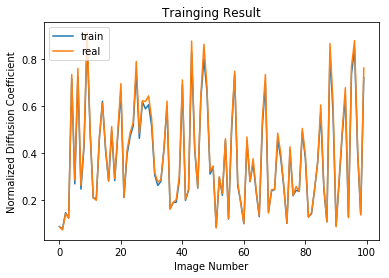

In [5]:
x=[]
for i in range(100):
    x.append(i)

pred=model.predict(X_train)

fig = plt.figure()
ax=fig.add_subplot(1,1,1)

ax.plot(x,pred[0:100], label='train')
ax.plot(x,Y_train[0:100],label='real')
plt.legend()
ax.set_title('Trainging Result')
ax.set_xlabel('Image Number')
ax.set_ylabel('Normalized Diffusion Coefficient')

# plt.savefig('training_result_2.png',dpi=400)

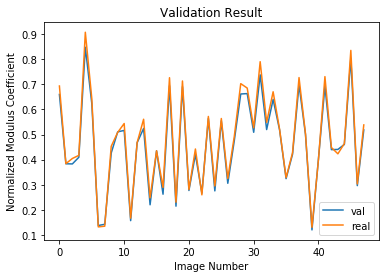

In [6]:
x=[]
for i in range(48):
    x.append(i)

pred=model.predict(X_val)

fig = plt.figure()
ax=fig.add_subplot(1,1,1)

ax.plot(x,pred, label='val')
ax.plot(x,Y_val,label='real')
plt.legend()
ax.set_title('Validation Result')
ax.set_xlabel('Image Number')
ax.set_ylabel('Normalized Modulus Coefficient')

0.0073635397568


/home/conebeam/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in divide


"\nfig2 = plt.figure()\nax2 = fig2.add_subplot(1,1,1)\nax2.plot(x,se[0:100])\nax2.set_xlabel('Image Number')\nax2.set_ylabel('Difference')\n"

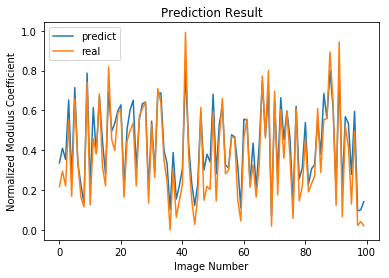

In [16]:
x=[]
for i in range(100):
    x.append(i)

pred=model.predict(X_test)
print(mean_squared_error(Y_test, pred))

fig1 = plt.figure()
ax1=fig1.add_subplot(1,1,1)

ax1.plot(x,pred[0:100], label='predict')
ax1.plot(x,Y_test[0:100],label='real')
plt.legend()
ax1.set_title('Prediction Result')
ax1.set_xlabel('Image Number')
ax1.set_ylabel('Normalized Modulus Coefficient')

se = np.zeros([240])
for i in range(240):
    se[i] = (pred[i]-Y_test[i])/Y_test[i]


'''
fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)
ax2.plot(x,se[0:100])
ax2.set_xlabel('Image Number')
ax2.set_ylabel('Difference')
'''
# plt.savefig('prediction_result_2.png',dpi=400)

In [41]:
count = 0
for i in range(240):
    if np.abs(se[i])>=0.3:
        count += 1
        
count

108

In [30]:
threshold = 0.3
def find_image_nb(Input):
    image_nb = []
    for i in range(len(Input)):
        if abs(Input[i]) >= threshold:
            image_nb.append(i)
            
    return image_nb

In [32]:
image_nb = find_image_nb(se)
diff_test = X_test[image_nb]

In [21]:
# np.size(image_nb)
image_nb[4]

7

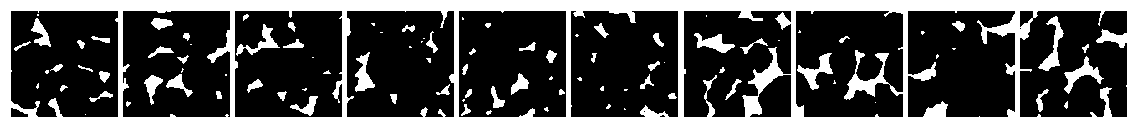

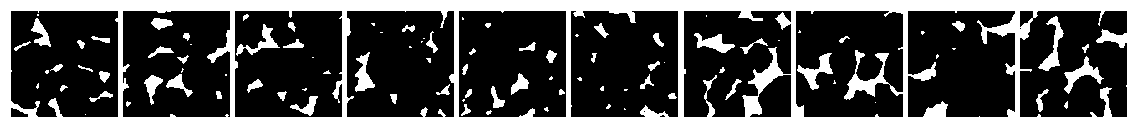

In [34]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10,10))

'''
ax1=fig.add_subplot(1,2,1)
plt.axis('off')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.imshow(X_test[7].reshape(128,128))

ax1=fig.add_subplot(1,2,2)
plt.axis('off')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.imshow(diff_test[4].reshape(128,128))
'''

def plot(samples):
    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(1, 10)
    gs.update(wspace=0.05, hspace=0.0)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.imshow(sample.reshape(128, 128), cmap='Greys_r')

plot(X_test[image_nb[:10]])
plot(diff_test[:10])

In [35]:
diff_test.shape
# np.size(image_nb)

(110, 128, 128, 1)

In [ ]:
diff_test = diff_test[:90]
image_nb = image_nb[:90]
sio.savemat('diff_fig.mat',{'img':diff_test, 'index':image_nb})

In [10]:
model.evaluate(X_test, Y_test, batch_size=40)

240/240 [==============================] - 0s     


[0.0065099638110647602, 0.0065099638110647602]

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 24)      888       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 24)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        6944      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 48)        13872     
__________